# 1. BERT微调

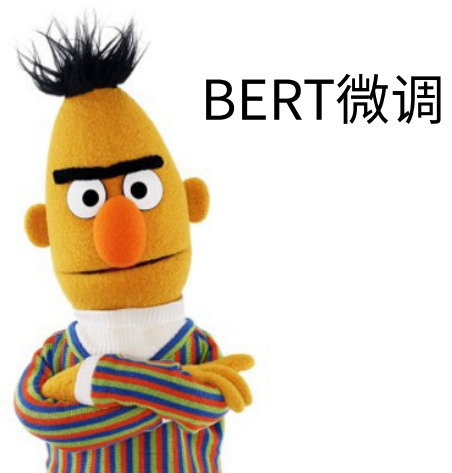

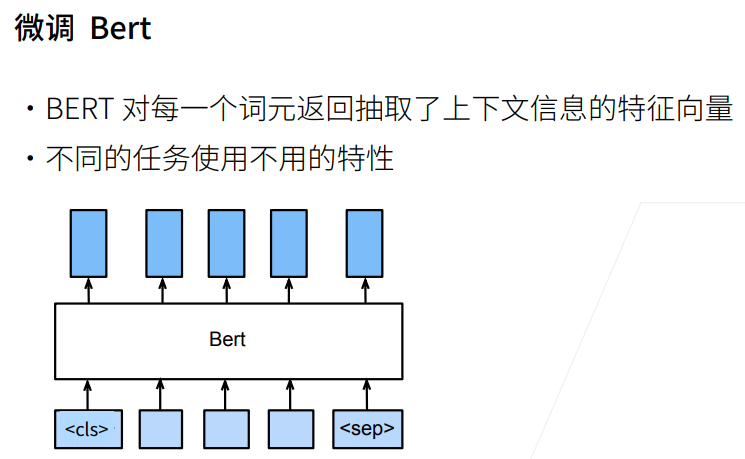

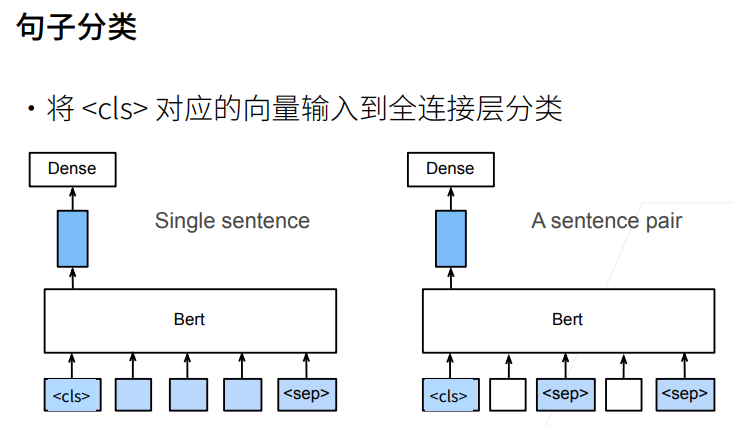

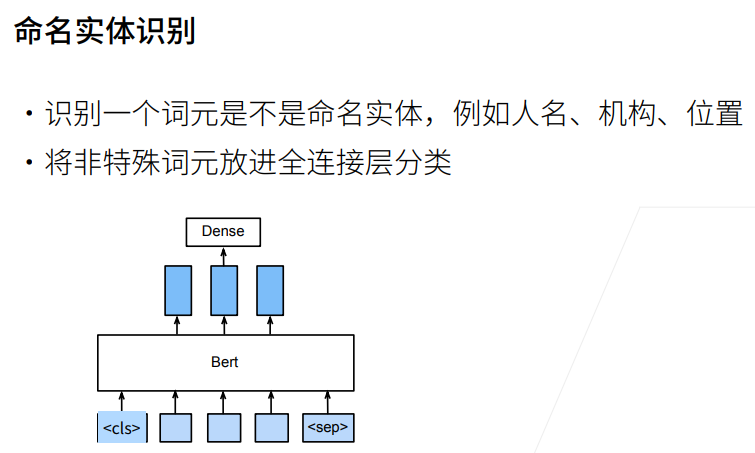

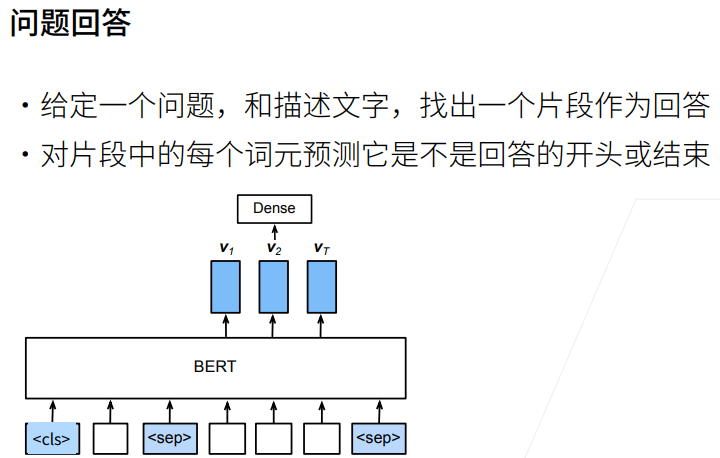

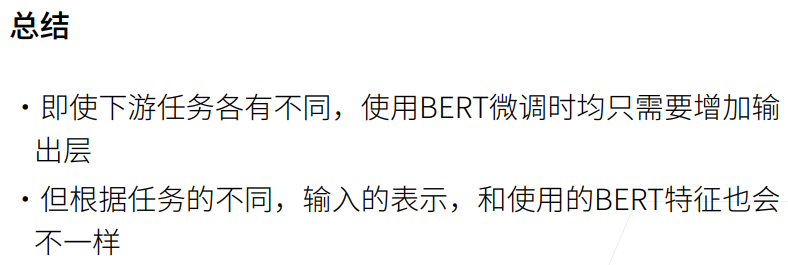

# 2. 自然语言推理和数据集

In [1]:
# Stanford Natural Language Inference(SNLI) Corpus
import os
import re
import torch
from torch import nn
from d2l import torch as d2l

# 将 SNLI 数据集添加到 d2l 的数据集存储库中
d2l.DATA_HUB['SNLI'] = ('https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
                        '9fcde07509c7e87ec61c640c1b2753d9041758e4') 
# 下载和提取 SNLI 数据集
data_dir = d2l.download_extract('SNLI')

OSError: [Errno 22] Invalid argument: '..\\data\\snli_1.0\\Icon\r'

① 报错后，手动解压缩下载的snli_1.0.zip文件，选择解压到当前文件夹，选择全部替换，并将解压文件夹所在路径赋值给data_dir。

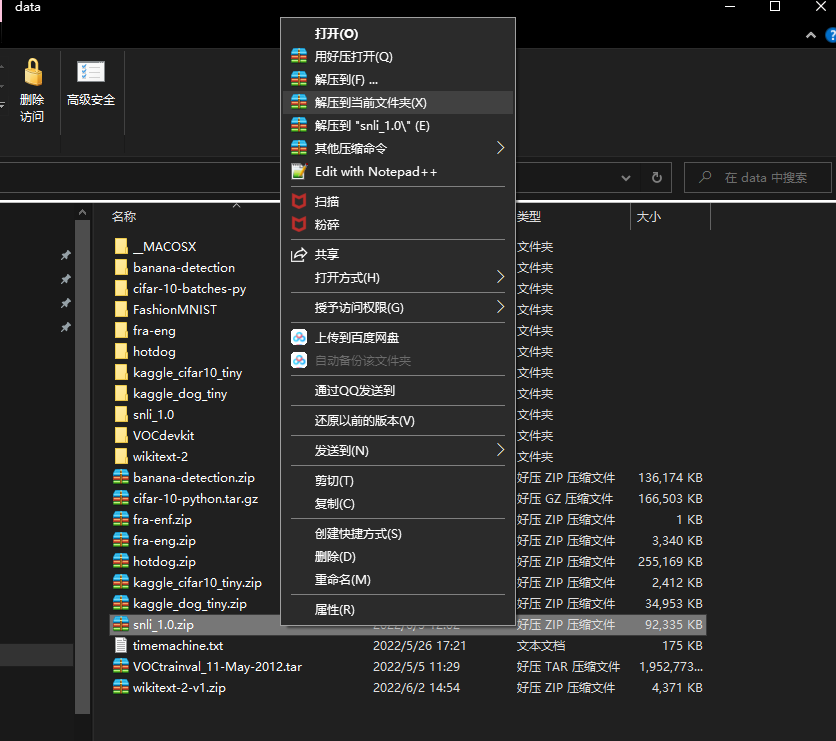

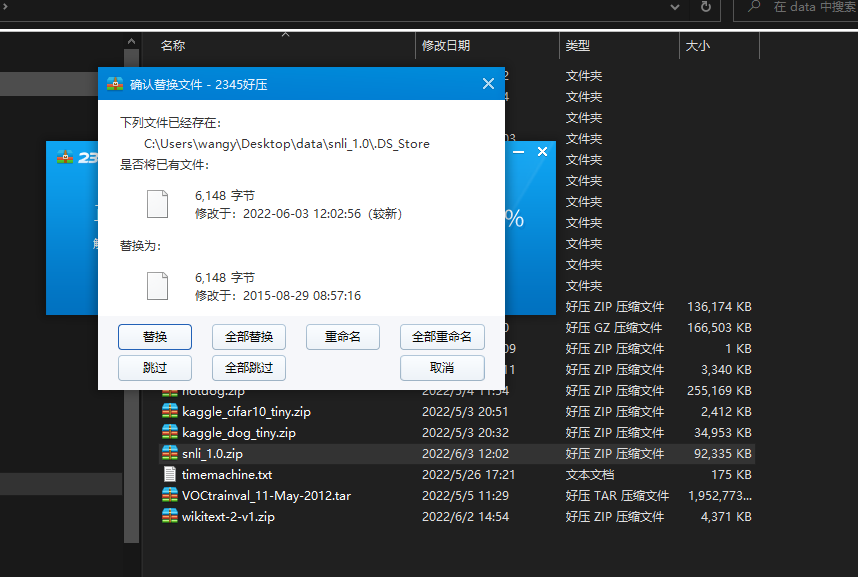

In [2]:
data_dir = "..\data\snli_1.0"

In [3]:
# Reading the Dataset
# 定义函数，用于处理文本数据
def read_snli(data_dir, is_train):
    """Read the SNLI dataset into premises, hypotheses, and labels. """
    # 定义函数，用于处理文本数据
    def extract_text(s):
        # 去除左括号
        s = re.sub('\\(', '', s)
        # 去除右括号
        s = re.sub('\\)', '', s)
        # 去除多余的空格
        s = re.sub('\\s{2,}', ' ', s)
        # 去除首尾空格
        return s.strip()
    # 标签映射表
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    # 根据是否是训练集选择相应的文件名
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt' 
                             if is_train else 'snli_1.0_test.txt')
    # 打开文件并逐行读取数据
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    # 提取前提、假设和标签
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [4]:
# Print the first 3 pairs
# 打印前三对数据
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('premise:', x0)
    print('hypothesis:', x1)
    print('label:', y)

premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is training his horse for a competition .
label: 2
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is at a diner , ordering an omelette .
label: 1
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is outdoors , on a horse .
label: 0


In [5]:
# Labels "entailment", "contradiction", and "neutral" are balanced
# 标签 "entailment"、"contradiction" 和 "neutral" 均衡
test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    # 打印结果显示了各个标签在数据集中的出现次数，用于验证它们是否均衡
    print([[row for row in data[2]].count(i) for i in range(3)])

[183416, 183187, 182764]
[3368, 3237, 3219]


In [6]:
# Defining a Class for Loading the Dataset
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset"""
    # 初始化方法
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        # 分词得到前提的标记列表
        all_premise_tokens = d2l.tokenize(dataset[0])
        # 分词得到假设的标记列表
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            # 构建词汇表
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                   min_freq=5, reserved_tokens=['<pad>']) 
        else:
            self.vocab = vocab
        # 填充后的前提标记张量
        self.premises = self._pad(all_premise_tokens)
        # 填充后的假设标记张量
        self.hypotheses = self._pad(all_hypothesis_tokens)
        # 标签张量
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examles')
        
    def _pad(self, lines):
        # 辅助方法，对标记列表进行填充
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line],self.num_steps,self.vocab['<pad>'])
                            for line in lines])
    
    def __getitem__(self, idx):
        # 获取数据项的方法
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx] 
    
    def __len__(self):
        # 返回数据集的长度
        return len(self.premises)

In [7]:
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset."""
    # 初始化方法
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        # 对前提进行分词得到标记列表
        all_premise_tokens = d2l.tokenize(dataset[0])
        # 对假设进行分词得到标记列表
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            # 构建词汇表对象
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                   min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        # 填充后的前提标记张量
        self.premises = self._pad(all_premise_tokens)
        # 填充后的假设标记张量
        self.hypotheses = self._pad(all_hypothesis_tokens)
        # 标签张量
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        # 辅助方法，对标记列表进行填充
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                         for line in lines])

    def __getitem__(self, idx):
        # 获取数据项的方法
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        # 返回数据集的长度
        return len(self.premises)

In [8]:
# Putting All Things Together
def load_data_snli(batch_size, num_steps=50):
    """Download the SNLI dataset and return data iterators and vocabulary."""  
    num_workers = 0
    data_dir = "..\data\snli_1.0"
    # 读取训练集数据
    train_data = read_snli(data_dir, True)
    # 读取测试集数据
    test_data = read_snli(data_dir, False)
    # 创建训练集数据集对象
    train_set = SNLIDataset(train_data, num_steps)
    # 创建测试集数据集对象，并共享训练集的词汇表
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    # 创建训练集数据迭代器
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, 
                                             shuffle=True, num_workers=num_workers)    
    # 创建测试集数据迭代器
    test_iter = torch.utils.data.DataLoader(test_set, batch_size, 
                                            shuffle=False, num_workers=num_workers)   
    return train_iter, test_iter, train_set.vocab

# 加载数据迭代器和词汇表
train_iter, test_iter, vocab = load_data_snli(128, 50)
# 词汇表的大小
len(vocab)

read 549367 examples
read 9824 examples


18678

In [9]:
for X, Y in train_iter:
    # 打印训练集中输入数据的形状（premises）
    print(X[0].shape)
    # 打印训练集中输入数据的形状（hypotheses）
    print(X[1].shape)
    # 打印训练集中标签数据的形状
    print(Y.shape)
    # 仅打印第一个批次的数据，然后退出循环
    break

torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])


# 3. 自然语言推理：微调BERT

In [10]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

In [11]:
# Loading Pretrained BERT
# 定义预训练的BERT模型的数据源链接和哈希值
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip', 
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [12]:
# Load pretrained BERT parameters
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    # 下载和提取预训练模型的数据文件
    data_dir = d2l.download_extract(pretrained_model)
    # 创建词汇表对象，并加载词汇表索引和标记的映射关系
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))  
    vocab.token_to_idx = {token: idx for idx, token in enumerate(vocab.idx_to_token)}   
    # 创建BERT模型对象
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4,num_layers=2,dropout=0.2,
                         max_len=max_len,key_size=256,query_size=256,
                         value_size=256,hid_in_features=256,
                         mlm_in_features=256,nsp_in_features=256)
    # 加载预训练的BERT参数
    bert.load_state_dict(torch.load(os.path.join(data_dir, 'pretrained.params')))  
    return bert, vocab
# 尝试使用所有可用的GPU设备
devices = d2l.try_all_gpus()
# 加载预训练的BERT模型和词汇表
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_layers=2, dropout=0.1, max_len=512, devices=devices)

In [13]:
# The Dataset for Fine-Tuning BERT
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        # 将前提和假设的文本转换为词元序列，并存储在all_premise_hypothesis_tokens中
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences]) 
              for sentences in dataset[:2]])]
        # 存储标签
        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        # 对所有前提和假设的词元序列进行预处理
        (self.all_token_ids, self.all_segments, 
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)   
        print('read ' + str(len(self.all_token_ids)) + ' examples')
    
    def _preprocess(self, all_premise_hypothesis_tokens):
        # 多进程处理词元序列
        out = map(self._mp_worker, all_premise_hypothesis_tokens)
        out = list(out)
        # 提取预处理后的结果
        all_token_ids = [token_ids for token_ids, segments, valid_len in out]   
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))
    
    def _mp_worker(self, premise_hypothesis_tokens):
        # 处理单个前提和假设的词元序列
        p_tokens, h_tokens = premise_hypothesis_tokens
        # 截断前提和假设的词元序列
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        # 获取词元和片段标记
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens) 
        # 将词元序列转换为索引序列，补齐至最大长度
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] * (self.max_len - len(tokens))   
        # 补齐片段标记至最大长度
        segments = segments + [0] * (self.max_len - len(segments))
        # 记录有效长度
        valid_len = len(tokens)
        return token_ids, segments, valid_len
    
    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 不断截断前提和假设的词元序列，使总长度不超过最大长度减3
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()
                
    def __getitem__(self, idx):
        # 返回数据样本和标签
        return (self.all_token_ids[idx], self.all_segments[idx], 
                self.valid_lens[idx]), self.labels[idx]
    
    def __len__(self):
        # 返回数据集的样本数量
        return len(self.all_token_ids)

In [14]:
# Generate training and testing examples
# 生成训练和测试样本
batch_size, max_len, num_workers = 512, 128, 0
data_dir = "..\data\snli_1.0"
# 创建训练集和测试集的 SNLIBERTDataset 对象
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)  
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)   
# 创建训练集和测试集的数据迭代器
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers = num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size, num_workers = num_workers)    

read 549367 examples
read 9824 examples


In [15]:
# This MLP transforms the BERT representation of the special "<cls>" token into three outputs of natural language inference
# 定义一个 MLP，将特殊的 "<cls>" 标记的 BERT 表示转换为三个自然语言推断的输出
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        # BERT 编码器
        self.encoder = bert.encoder
        # BERT 隐藏层
        self.hidden = bert.hidden
        # 输出层，将隐藏层的输出映射到三个类别
        self.output = nn.Linear(256, 3)
        
    def forward(self, inputs):
        # 输入数据
        tokens_X, segments_X, valid_lens_x = inputs
        # BERT 编码器的输出
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        # 将特殊标记的表示进行线性变换得到最终输出
        return self.output(self.hidden(encoded_X[:, 0, :]))
    
# 创建 BERTClassifier 对象
net = BERTClassifier(bert)

loss 0.521, train acc 0.790, test acc 0.779
3691.2 examples/sec on [device(type='cuda', index=0)]


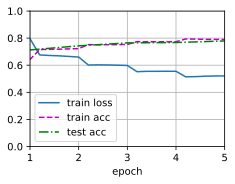

In [16]:
# The training
# 训练过程
# 学习率和训练轮数
lr, num_epochs = 1e-4, 5
# Adam 优化器
trainer = torch.optim.Adam(net.parameters(), lr=lr)
# 交叉熵损失函数，不进行降维
loss = nn.CrossEntropyLoss(reduction='none')
# 调用 d2l.train_ch13 函数进行模型的训练
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)   